In [1]:
### mc_utils file content

from numpy.polynomial.polynomial import Polynomial
from collections.abc import Iterable
from qiskit import *
import matplotlib.pyplot as plt
import math
import numpy as np
import copy

########## Classical math functions

def gaussian_dist(num_state_qubits, mu, sigma=0.3):
    if mu > 1:
        mu = 1
    if mu < 0:
        mu = 0
    if sigma < 1e-3:
        sigma = 1e-3
    
    dist = {}
    normalization = 0.5 * (math.erf((1-mu)/(np.sqrt(2)*sigma)) - math.erf((0-mu)/(np.sqrt(2)*sigma)))

    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        a = (i)/(2**num_state_qubits)
        b = (i+1)/(2**num_state_qubits)
        dist[key] = 0.5/normalization * (math.erf((b-mu)/(np.sqrt(2)*sigma)) - math.erf((a-mu)/(np.sqrt(2)*sigma)))
    return dist


def linear_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = (2*i+1)/(2**(2*num_state_qubits))
    return dist


def power_f(i, num_state_qubits, power):
    if isinstance(i, Iterable):
        out = []
        for val in i:
            out.append((val / ((2**num_state_qubits) - 1))**power)
        return np.array(out)
    else:
        return (i / ((2**num_state_qubits) - 1))**power
    
    
def estimated_value(target_dist, f):
    avg = 0
    for key in target_dist.keys():
        x = int(key,2)
        avg += target_dist[key]*f(x)
    return avg
    
    
    
def zeta_from_f(i, func, epsilon, degree, c):
    """
    Intermediate polynomial derived from f to serve as angle for controlled Ry gates.
    """
    rad = np.sqrt(c*(func(i) - 0.5) + 0.5)
    return np.arcsin(rad)



def simplex(n, k):
    """
    Get all ordered combinations of n integers (zero inclusive) which add up to k; the n-dimensional k simplex.
    """
    if k == 0:
        z = [0]*n
        return [z]
    l = [] 
    
    for p in simplex(n,k-1):
        
        for i in range(n):
            a = p[i]+1
            ns = copy.copy(p)
            ns[i] = a
            if ns not in l:
                l.append(ns)
    return l



def binary_expansion(num_state_qubits, poly):
    """
    Convert a polynomial into expression replacing x with its binary decomposition x_0 + 2 x_1 + 4 x_2 + ... 
    
    Simplify using (x_i)^p = x_i for all integer p > 0 and collect coefficients of equivalent expression
    
    """
    n = num_state_qubits
    if isinstance(poly, Polynomial):
        poly_c = poly.coef
    else:
        poly_c = poly
        
    out_front = {}
    out_front[()] = poly_c[0]
    for k in range(1,len(poly_c)):
        for pow_list in simplex(n,k):
            two_exp, denom, t = 0, 1, 0
            for power in pow_list:
                two_exp += t*power
                denom *= np.math.factorial(power)
                t+=1
            nz = np.nonzero(pow_list)[0]
            key = tuple(nz)
            if key not in out_front.keys():
                out_front[key] = 0
            out_front[key] += poly_c[k]*((np.math.factorial(k) / denom) * (2**(two_exp)))
    return out_front


def starting_regions(num_state_qubits):
    """
    For use in bisection search for state preparation subroutine. Fill out the necessary region labels for num_state_qubits.    
    """
    sub_regions = []
    sub_regions.append(['1'])
    for d in range(1,num_state_qubits):
        region = []
        for i in range(2**d):
            key = bin(i)[2:].zfill(d) + '1'
            region.append(key)
        sub_regions.append(region)
        
    return sub_regions



def region_probs(target_dist, num_state_qubits):
    """
    Fetch bisected region probabilities for the desired probability distribution {[p1], [p01, p11], [p001, p011, p101, p111], ...}.
    """
    
    regions = starting_regions(num_state_qubits)
    probs = {}
    n = len(regions)
    for k in range(n):
        for string in regions[k]:
            p = 0
            b = n-k-1
            for i in range(2**b):
                subkey = bin(i)[2:].zfill(b)
                if b == 0:
                    subkey = ''
                try:
                    p += target_dist[string+subkey]
                except KeyError:
                    pass
            probs[string] = p
    return probs


def mc_dist(num_counting_qubits, exact, c_star, method):
    """
    Creates the probabilities of measurements we should get from the phase estimation routine
    
    Taken from Eq. (5.25) in Nielsen and Chuang
    """
    # shift exact value into phase phi which the phase estimation approximates
    if method == 1:
        unshifted_exact = ((exact - 0.5)*c_star) + 0.5
    elif method == 2:
        unshifted_exact = exact
    phi = np.arcsin(np.sqrt(unshifted_exact))/np.pi 

    dist = {}
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    for b in range(2**num_counting_qubits):
        
        # Eq. (5.25), gives probability for measuring an integer (b) after phase estimation routine
        # if phi is too close to b, results in 0/0, but acutally should be 1
        if abs(phi-b/(2**num_counting_qubits)) > 1e-6:
            prob = np.abs(((1/2)**num_counting_qubits) * (1-np.exp(2j*np.pi*(2**num_counting_qubits*phi-b))) / (1-np.exp(2j*np.pi*(phi-b/(2**num_counting_qubits)))))**2
        else:
            prob = 1.0
        
        # calculates the predicted expectation value if measure b in the counting qubits
        a_meas = pow(np.sin(np.pi*b/pow(2,num_counting_qubits)),2)
        if method == 1:
            a = ((a_meas - 0.5)/c_star) + 0.5
        elif method == 2:
            a = a_meas
        a = round(a, precision)

        # generates distribution of expectation values and their relative probabilities
        if a not in dist.keys():
            dist[a] = 0
        dist[a] += prob
    
    return dist


def value_and_max_prob_from_dist(dist):
    """
    Returns the max probability and value from a distribution:
    Ex: From: {0.0: 0.1, 0.33: 0.4, 0.66: 0.2, 1.0: 0.3}
        Returns: (0.33, 0.4)
    """
    value = max(dist, key = dist.get)
    max_prob = dist[value]

    return value, max_prob

In [2]:
"""
Monte Carlo Sampling Benchmark Program via Amplitude Estimation- Qiskit
"""

import copy
import functools
import sys
import time

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates.ry import RYGate

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 1.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]


np.random.seed(0)

# default function is f(x) = x^2
f_of_X = functools.partial(power_f, power=2)

# default distribution is gaussian distribution
p_distribution = gaussian_dist

verbose = False

# saved circuits and subcircuits for display
A_ = None
Q_ = None
cQ_ = None
QC_ = None
R_ = None
F_ = None
QFTI_ = None


In [3]:
num_gates = 0
depth = 0
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc

In [4]:
############### Circuit Definition

def MonteCarloSampling(target_dist, f, num_state_qubits, num_counting_qubits, epsilon=0.05, degree=2, method=2):
    
    A_qr = QuantumRegister(num_state_qubits+1)
    A = QuantumCircuit(A_qr, name="A")

    num_qubits = num_state_qubits + 1 + num_counting_qubits
    
    # initialize R and F circuits
    R_qr = QuantumRegister(num_state_qubits+1)
    F_qr = QuantumRegister(num_state_qubits+1)
    R = QuantumCircuit(R_qr, name="R")
    F = QuantumCircuit(F_qr, name="F")
    
    # method 1 takes in the abitrary function f and arbitrary dist
    if method == 1:
        state_prep(R, R_qr, target_dist, num_state_qubits)
        f_on_objective(F, F_qr, f, epsilon=epsilon, degree=degree)
    # method 2 chooses to have lower circuit depth by choosing specific f and dist
    elif method == 2:
        uniform_prep(R, R_qr, num_state_qubits)
        square_on_objective(F, F_qr)

    # append R and F circuits to A
    A.append(R.to_gate(), A_qr)
    A.append(F.to_gate(), A_qr)

    # run AE subroutine given our A composed of R and F
    qc = AE_Subroutine(num_state_qubits, num_counting_qubits, A, method)

    # save smaller circuit example for display
    global QC_, R_, F_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    if (R_ and F_) == None or num_state_qubits <= 3:
        if num_state_qubits < 5: R_ = R; F_ = F
    
    return qc    

###############              
                    
def f_on_objective(qc, qr, f, epsilon=0.05, degree=2):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_state_qubits = qc.num_qubits - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_state_qubits=num_state_qubits)
    zeta_ = functools.partial(zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x_eval = np.linspace(0.0, 2**(num_state_qubits) - 1, num= degree+1)
    poly = Polynomial(polyfit(x_eval, zeta_(x_eval), degree))
    
    b_exp = binary_expansion(num_state_qubits, poly)
    
    for controls in b_exp.keys():
        theta = 2*b_exp[controls]
        controls = list(controls)
        if len(controls)==0:
            qc.ry(-theta, qr[num_state_qubits])
        else:
            # define a MCRY gate:
            # this does the same thing as qc.mcry, but is clearer in the circuit printing
            MCRY = RYGate(-theta).control(len(controls))
            qc.append(MCRY, [*(qr[i] for i in controls), qr[num_state_qubits]])

def square_on_objective(qc, qr):
    """
    Assume last qubit is the objective.
    Shifted square wave function: if x is even, f(x) = 0; if x i s odd, f(x) = 1
    """
    num_state_qubits = qc.num_qubits - 1
    for control in range(num_state_qubits):
        qc.cx(control, num_state_qubits)

def state_prep(qc, qr, target_dist, num_state_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = region_probs(target_dist, num_state_qubits)
    regions = r_probs.keys()
    r_norm = {}
    
    for r in regions:
        num_controls = len(r) - 1
        super_key = r[:num_controls]

        if super_key=='':
            r_norm[super_key] = 1
        elif super_key == '1':
            r_norm[super_key] = r_probs[super_key]
            r_norm['0'] = 1-r_probs[super_key]
        else:
            try:
                r_norm[super_key] = r_probs[super_key]
                
            except KeyError:
                r_norm[super_key] = r_norm[super_key[:num_controls-1]] - r_probs[super_key[:num_controls-1] + '1']
        
        
        norm = r_norm[super_key]
        p = 0
        if norm != 0:
            p = r_probs[r] / norm
        theta = 2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.ry(-theta, num_state_qubits-1)
        else:
            controls = [qr[num_state_qubits-1 - i] for i in range(num_controls)]
            
            # define a MCRY gate:
            # this does the same thing as qc.mcry, but is clearer in the circuit printing
            MCRY = RYGate(-theta).control(num_controls, ctrl_state=r[:-1])
            qc.append(MCRY, [*controls, qr[num_state_qubits-1 - num_controls]])

def uniform_prep(qc, qr, num_state_qubits):
    """
    Generates a uniform distribution over all states
    """
    for i in range(num_state_qubits):
        qc.h(i)
            
def AE_Subroutine(num_state_qubits, num_counting_qubits, A_circuit, method):

    num_qubits = num_state_qubits + num_counting_qubits
    
    qr_state = QuantumRegister(num_state_qubits+1)
    qr_counting = QuantumRegister(num_counting_qubits)
    cr = ClassicalRegister(num_counting_qubits)
    qc = QuantumCircuit(qr_state, qr_counting, cr, name=f"qmc({method})-{num_qubits}-{0}")

    A = A_circuit
    cQ, Q = Ctrl_Q(num_state_qubits, A)

    # save small example subcircuits for visualization
    global A_, Q_, cQ_, QFTI_
    if (cQ_ and Q_) == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ; Q_ = Q
    if A_ == None or num_state_qubits <= 3:
        if num_state_qubits < 5: A_ = A
    if QFTI_ == None or num_counting_qubits <= 3:
        if num_counting_qubits < 4: QFTI_ = inv_qft_gate(num_counting_qubits)

    # Prepare state from A, and counting qubits with H transform 
    qc.append(A, qr_state)
    for i in range(num_counting_qubits):
        qc.h(qr_counting[i])
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc.append(cQ, [qr_counting[j]] + [qr_state[l] for l in range(num_state_qubits+1)])
        repeat *= 2
    
    qc.barrier()
    
    # inverse quantum Fourier transform only on counting qubits
    qc.append(inv_qft_gate(num_counting_qubits), qr_counting)
    
    qc.barrier()
    
    qc.measure([qr_counting[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)))
    
    return qc
            
            
###############################
   
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qc = QuantumCircuit(num_state_qubits+1, name="Q")
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc.x(num_state_qubits)
    qc.z(num_state_qubits)
    qc.x(num_state_qubits)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_state_qubits+1)])
        
    # S_0
    for i in range(num_state_qubits+1):
        qc.x(i)
    qc.h(num_state_qubits)
    
    qc.mcx([x for x in range(num_state_qubits)], num_state_qubits)
    
    qc.h(num_state_qubits)
    for i in range(num_state_qubits+1):
        qc.x(i)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_state_qubits+1)])
    
    # Create a gate out of the Q operator
    qc.to_gate(label='Q')
    
    # and also a controlled version of it
    Ctrl_Q_ = qc.control(1)
    
    # and return both
    return Ctrl_Q_, qc

In [5]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    #print("in polarization fidelity:",correct_dist)
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

In [6]:
def a_to_bitstring(a, num_counting_qubits):
    m = num_counting_qubits

    # solution 1
    num1 = round(np.arcsin(np.sqrt(a)) / np.pi * 2**m)
    num2 = round( (np.pi - np.arcsin(np.sqrt(a))) / np.pi * 2**m)
    if num1 != num2 and num2 < 2**m and num1 < 2**m:
        counts = {format(num1, "0"+str(m)+"b"): 0.5, format(num2, "0"+str(m)+"b"): 0.5}
    else:
        counts = {format(num1, "0"+str(m)+"b"): 1}
    return counts

def expectation_from_bits(bits, num_qubits, num_shots, method):
    amplitudes = {}
    for b in bits.keys():
        precision = int(num_qubits / (np.log2(10))) + 2

        r = bits[b]
        a_meas = pow(np.sin(np.pi*int(b,2)/pow(2,num_qubits)),2)
        if method == 1:
            a = ((a_meas - 0.5)/c_star) + 0.5
        if method == 2:
            a = a_meas
        a = round(a, precision)
        
        if a not in amplitudes.keys():
            amplitudes[a] = 0
        amplitudes[a] += r
    
    return amplitudes

In [7]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())
    print("avg_num_qubits_values",avg_num_qubits_values)
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    # print(fidelity_data)
    # print(Hf_fidelity_data)
    # print(avg_fidelity_means)
    # print(avg_Hf_fidelity_means)

************
Executing [1] circuits with num_qubits = 4
qc of 4 qubits of type <class 'type'>
      ┌───┐ ┌──────┐                 ░ ┌──────────┐ ░    ┌─┐
q4_0: ┤ H ├─┤0     ├─────────────────░─┤1         ├─░────┤M├
      ├───┤ │      │┌──────┐┌──────┐ ░ │  inv_qft │ ░ ┌─┐└╥┘
q4_1: ┤ H ├─┤      ├┤0     ├┤0     ├─░─┤0         ├─░─┤M├─╫─
      ├───┴┐│  c_Q ││      ││      │ ░ └──────────┘ ░ └╥┘ ║ 
q3_0: ┤1   ├┤2     ├┤2 c_Q ├┤2 c_Q ├─░──────────────░──╫──╫─
      │  A ││      ││      ││      │ ░              ░  ║  ║ 
q3_1: ┤0   ├┤1     ├┤1     ├┤1     ├─░──────────────░──╫──╫─
      └────┘└──────┘└──────┘└──────┘ ░              ░  ║  ║ 
c0: 2/═════════════════════════════════════════════════╩══╩═
                                                       1  0 
prob {'00': 0.0, '01': 0.5, '10': 0.0, '11': 0.5}
counts= {'00': 0, '01': 50, '10': 0, '11': 50}
2
fidelity_dict = {'fidelity': 1.0, 'hf_fidelity': 1.0}
hf_fidelity_dict = 1.0
For expected value 0.5 measured: 01
Solution counts: {'00':

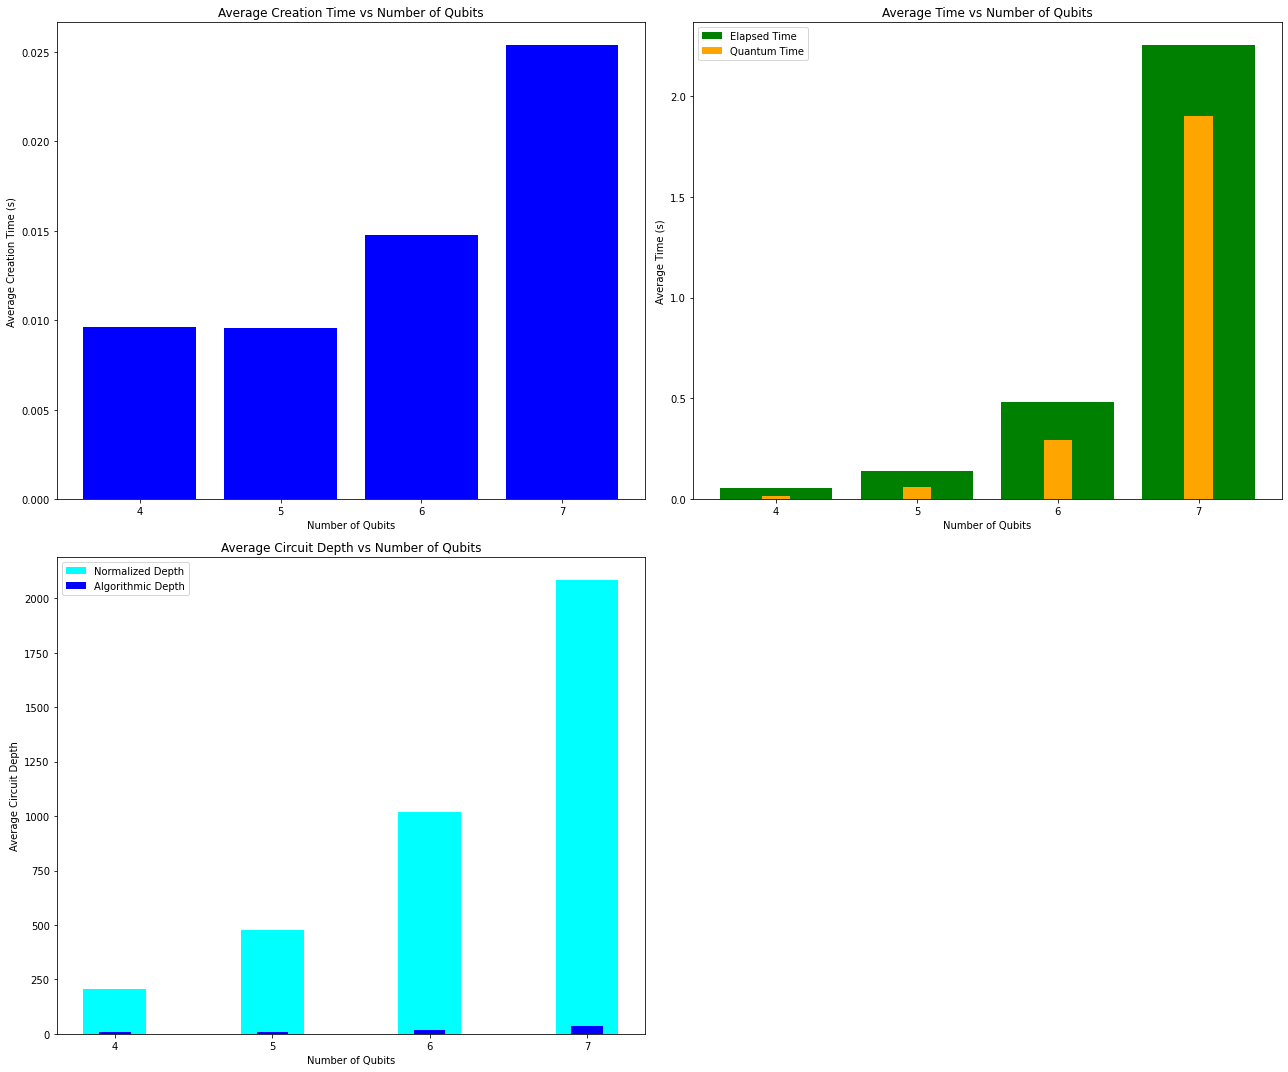

avg_num_qubits_values [4, 5, 6, 7]


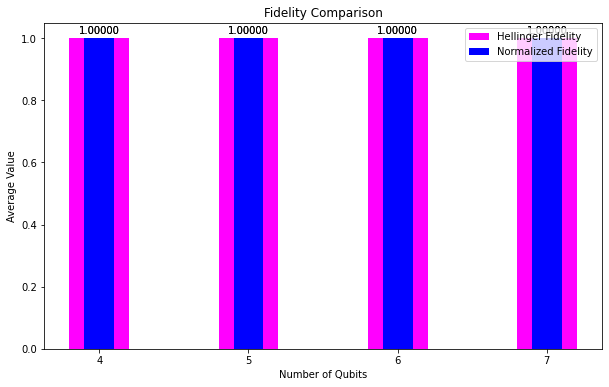

In [8]:
################ Benchmark Loop

backend = BasicAer.get_backend('dm_simulator')

MIN_QUBITS = 4    # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS = 1

# set minimums for method 1
MIN_QUBITS_M1 = 5 # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS_M1 = 2

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=10

# Execute program with default parameters
def run(min_qubits=MIN_QUBITS, max_qubits=7, skip_qubits=1, max_circuits=1, num_shots=100,
        epsilon=0.05, degree=2, num_state_qubits=MIN_STATE_QUBITS, method = 2):

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: {benchmark_name} benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
    
    if (method == 2):
        if max_qubits < MIN_QUBITS:
            print(f"INFO: {benchmark_name} benchmark method ({method}) requires a minimum of {MIN_QUBITS} qubits.")
            return
        if min_qubits < MIN_QUBITS:
            min_qubits = MIN_QUBITS
    
    elif (method == 1):
        if max_qubits < MIN_QUBITS_M1:
            print(f"INFO: {benchmark_name} benchmark method ({method}) requires a minimum of {MIN_QUBITS_M1} qubits.")
            return
        if min_qubits < MIN_QUBITS_M1:
            min_qubits = MIN_QUBITS_M1

    if (method == 1) and (num_state_qubits == MIN_STATE_QUBITS):
        num_state_qubits = MIN_STATE_QUBITS_M1
    
    skip_qubits = max(1, skip_qubits)
    ### TODO: need to do more validation of arguments, e.g. min_state_qubits and min_qubits

    global max_ckts
    max_ckts = max_circuits

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}

    global min_qbits,max_qbits

    min_qbits = min_qubits
    max_qbits = max_qubits

    ##########
    
    global c_star
    c_star = (2*epsilon)**(1/(degree+1))

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):

        # reset random seed
        np.random.seed(0)

        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []

        input_size = num_qubits - 1 # TODO: keep using inputsize? only used in num_circuits
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (input_size), max_circuits)
        #print(num_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # determine range of circuits to loop over for method 1
        if 2**(input_size) <= max_circuits:
            mu_range = [i/2**(input_size) for i in range(num_circuits)]
        else:
            mu_range = [i/2**(input_size) for i in np.random.choice(2**(input_size), num_circuits, False)]

        #print(mu_range)
        
        # loop over limited # of mu values for this
        for mu in mu_range:
            target_dist = p_distribution(num_state_qubits, mu)
            f_to_estimate = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
            
            #print(mu)
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            qc = MonteCarloSampling(target_dist, f_to_estimate, num_state_qubits, num_counting_qubits, epsilon, degree, method=method).reverse_bits()
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)
            
            # collapse the 4 sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose().decompose().decompose().decompose()


            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)

            #ensemble probability
            prob = result.results[0].data.partial_probability
            print("prob",prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            # generate exact value for the expectation value given our function and dist
            target_dist = p_distribution(num_state_qubits, mu)
            f = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
            if method == 1:
                exact = estimated_value(target_dist, f)
            elif method == 2:
                exact = 0.5 # hard coded exact value from uniform dist and square function

            # calculate the expected output histogram
            correct_dist = a_to_bitstring(exact, num_counting_qubits)
        
            # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
            thermal_dist = uniform_dist(num_counting_qubits)

            # convert counts, expectation, and thermal_dist to app form for visibility
            # app form of correct distribution is measuring the input a 100% of the time
            # convert bit_counts into expectation values counts according to Quantum Risk Analysis paper
            app_counts = expectation_from_bits(counts, num_counting_qubits, num_shots, method)
            app_correct_dist = mc_dist(num_counting_qubits, exact, c_star, method)
            app_thermal_dist = expectation_from_bits(thermal_dist, num_counting_qubits, num_shots, method)

            # print(f"For expected value {exact}, expected: {correct_dist} measured: {counts}")
            # print(f"   ... For expected value {exact} thermal_dist: {thermal_dist}")
            # print(f"For expected value {exact}, app expected: {app_correct_dist} measured: {app_counts}")
            # print(f"   ... For expected value {exact} app_thermal_dist: {app_thermal_dist}")

            fidelity_dict = polarization_fidelity(counts, correct_dist, thermal_dist)
            hf_fidelity_dict = hellinger_fidelity_with_expected(counts, correct_dist)

            print("fidelity_dict =",fidelity_dict)
            print("hf_fidelity_dict =",hf_fidelity_dict)
            
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])

            ###########################################################################
            # NOTE: in this benchmark, we are testing how well the amplitude estimation routine
            #       works according to theory, and we do not measure the difference between
            #       the reported answer and the correct answer; the below code just helps
            #       demonstrate that we do approximate the expectation value accurately.
        
            # the max in the counts is what the algorithm would report as the correct answer
            a, _ = value_and_max_prob_from_dist(counts)
        
            print(f"For expected value {exact} measured: {a}")
            ###########################################################################
        
            print(f"Solution counts: {counts}")
            
            print(f"  ... fidelity: {fidelity_dict}  hf_fidelity: {hf_fidelity_dict}")
            # if method is 2, we only have one type of circuit, so break out of loop
            #if method == 2:
            #    break
        ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Quantum Operator 'cQ' ="); print(cQ_ if cQ_ != None else " ... too large!")
    print("\nQuantum Operator 'Q' ="); print(Q_ if Q_ != None else " ... too large!")
    print("\nAmplitude Generator 'A' ="); print(A_ if A_ != None else " ... too large!")
    print("\nDistribution Generator 'R' ="); print(R_ if R_ != None else " ... too large!")
    print("\nFunction Generator 'F' ="); print(F_ if F_ != None else " ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")
    
    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")